<a href="https://colab.research.google.com/github/Chivans31/Image-Classification-using-Deep-Learning/blob/main/Copy_of_DL_Assessement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt
import os

In [2]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [3]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/trolukovich/food11-image-dataset/') # insert ypu kaggle username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chinenyevans
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset


100%|██████████| 1.08G/1.08G [00:57<00:00, 20.3MB/s]


In [4]:
data_folder = "/content/food11-image-dataset"


In [5]:
main_dirs = os.listdir(data_folder)
main_dirs

['validation', 'training', 'evaluation']

In [6]:
# List the subdirectories and files in each main directory
for main_dir in main_dirs:
    path = os.path.join(data_folder, main_dir)
    if os.path.isdir(path):
        fruits = os.listdir(path)
        print(f"\nContents of {main_dir} directory:")
        for fruit in fruits:
            print(fruit)


Contents of validation directory:
Fried food
Soup
Vegetable-Fruit
Egg
Noodles-Pasta
Dessert
Dairy product
Bread
Rice
Meat
Seafood

Contents of training directory:
Fried food
Soup
Vegetable-Fruit
Egg
Noodles-Pasta
Dessert
Dairy product
Bread
Rice
Meat
Seafood

Contents of evaluation directory:
Fried food
Soup
Vegetable-Fruit
Egg
Noodles-Pasta
Dessert
Dairy product
Bread
Rice
Meat
Seafood


In [7]:
#Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:

total_dataset = datasets.ImageFolder("/content/food11-image-dataset")
train_dataset = datasets.ImageFolder("/content/food11-image-dataset/training", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/food11-image-dataset/evaluation", transform=test_transform)
val_dataset = datasets.ImageFolder("/content/food11-image-dataset/validation", transform=val_transform)

print(f'total dataset has {len(total_dataset)} samples')
print(f'Train set has {len(train_dataset)} samples')
print(f'Test set has {len(test_dataset)} samples')
print(f'Validation set has {len(val_dataset)} samples')

total dataset has 16643 samples
Train set has 9866 samples
Test set has 3347 samples
Validation set has 3430 samples


In [9]:
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

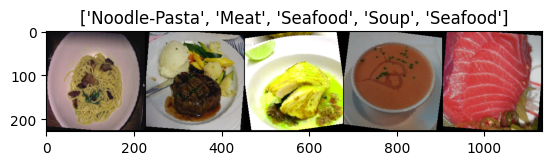

In [10]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
train_loader_for_vis = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodle-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

imshow(out, title=[class_names[x] for x in classes])

##Model

In [11]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 16)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [12]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

##Define Loss and Optimizer##

In [13]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


##Train and Validation##

In [ ]:
# The number of training epochs.
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=2.25885, acc=0.17983 | Valid: loss=2.20102, acc=0.19801


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=2.19257, acc=0.22081 | Valid: loss=2.15803, acc=0.23081


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=2.14325, acc=0.23977 | Valid: loss=2.08046, acc=0.26321


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=2.09081, acc=0.25856 | Valid: loss=2.07080, acc=0.26427


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=2.05512, acc=0.27468 | Valid: loss=2.01304, acc=0.29128


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=2.00773, acc=0.29225 | Valid: loss=1.98323, acc=0.28472


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=1.97873, acc=0.30166 | Valid: loss=1.97310, acc=0.30131


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=1.95026, acc=0.31487 | Valid: loss=1.94737, acc=0.31327


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=1.92409, acc=0.32844 | Valid: loss=1.93570, acc=0.32706


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=1.90168, acc=0.33639 | Valid: loss=1.90473, acc=0.32938


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=1.87841, acc=0.34369 | Valid: loss=1.85160, acc=0.35069


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=1.84606, acc=0.35589 | Valid: loss=1.82925, acc=0.36323


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=1.82286, acc=0.36379 | Valid: loss=1.80968, acc=0.36844


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=1.79841, acc=0.36992 | Valid: loss=1.80092, acc=0.36545


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=1.77957, acc=0.38279 | Valid: loss=1.78551, acc=0.36362


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=1.74926, acc=0.38979 | Valid: loss=1.81032, acc=0.35966


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=1.72892, acc=0.39563 | Valid: loss=1.75250, acc=0.39255


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=1.71235, acc=0.40301 | Valid: loss=1.77319, acc=0.38098


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=1.68820, acc=0.40854 | Valid: loss=1.72518, acc=0.39593


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=1.66712, acc=0.42154 | Valid: loss=1.73935, acc=0.39236


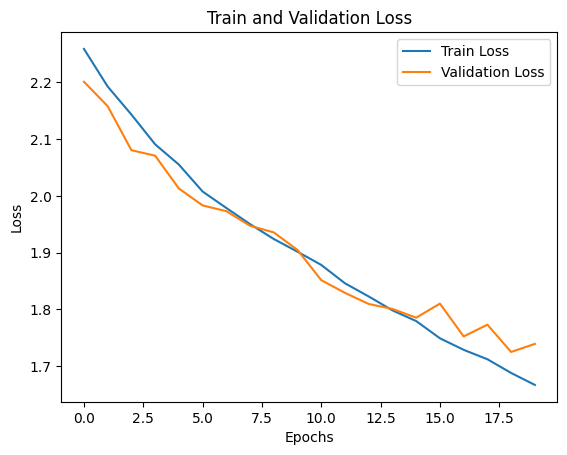

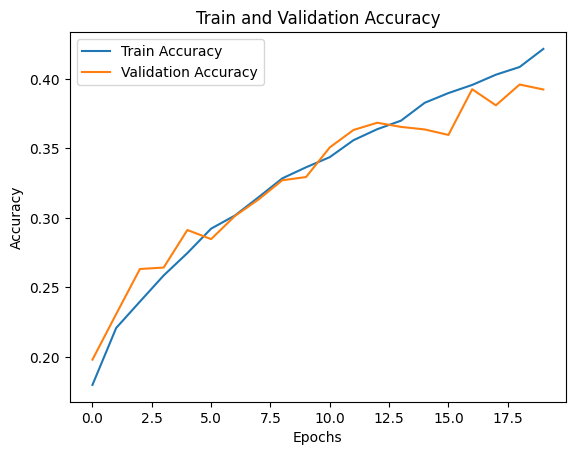

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

##Testing

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/105 [00:00<?, ?it/s]

Test accuracy 0.41314223408699036


##7. Improve Performance
##7.1 Data Augmentation

In [14]:
# Define transformations
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(size=224),  # Random crop and resize
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Adjust color
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
# ])
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # Additional augmentation
    transforms.RandomRotation(degrees=15),  # Increase rotation degree
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),  # Enhance jitter parameters
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random cropping
    transforms.RandomGrayscale(p=0.1),  # Occasionally convert images to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [15]:
train_dataset = datasets.ImageFolder("/content/food11-image-dataset/training", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/food11-image-dataset/evaluation", transform=test_transform)
val_dataset = datasets.ImageFolder("/content/food11-image-dataset/validation", transform=val_transform)

In [16]:
batch_size = 16

# Construct data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Modified Model architecture
class MyTunedCNN(nn.Module):
    def __init__(self):
        super(MyTunedCNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128*28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 16)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [18]:
# Updated hyperparameters
from torch.optim.lr_scheduler import StepLR
learning_rate = 0.001  # Changed learning rate
batch_size = 16 # Changed batch size
optimizer_type = torch.optim.SGD  # Changed optimizer
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

In [19]:
# Initialize model and move to device
Tuned_model = MyTunedCNN().to(device)
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optimizer_type(Tuned_model.parameters(), lr=learning_rate)

In [ ]:
# The number of training epochs.
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    Tuned_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = Tuned_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        scheduler.step()  # Step the scheduler after each epoch

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    Tuned_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = Tuned_model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(Tuned_model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=2.48006, acc=0.15201 | Valid: loss=2.30624, acc=0.17723


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=2.28776, acc=0.17235 | Valid: loss=2.28136, acc=0.18731


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=2.25514, acc=0.19261 | Valid: loss=2.23960, acc=0.19922


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=2.22823, acc=0.20636 | Valid: loss=2.19369, acc=0.21415


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=2.21302, acc=0.21132 | Valid: loss=2.21083, acc=0.18653


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=2.19574, acc=0.21882 | Valid: loss=2.15692, acc=0.22965


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=2.17661, acc=0.22964 | Valid: loss=2.13733, acc=0.23769


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=2.16223, acc=0.23280 | Valid: loss=2.12741, acc=0.25630


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=2.15104, acc=0.24040 | Valid: loss=2.10458, acc=0.25833


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=2.13520, acc=0.25093 | Valid: loss=2.09572, acc=0.26163


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=2.12421, acc=0.25004 | Valid: loss=2.08910, acc=0.25252


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=2.10845, acc=0.26031 | Valid: loss=2.07065, acc=0.26647


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=2.10710, acc=0.26029 | Valid: loss=2.05906, acc=0.27800


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=2.09836, acc=0.26440 | Valid: loss=2.03993, acc=0.28450


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=2.07824, acc=0.26528 | Valid: loss=2.06008, acc=0.26328


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=2.06816, acc=0.26838 | Valid: loss=2.02252, acc=0.27752


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=2.06041, acc=0.28118 | Valid: loss=2.00817, acc=0.30339


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=2.04933, acc=0.27980 | Valid: loss=1.99801, acc=0.29554


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=2.03569, acc=0.28604 | Valid: loss=1.97567, acc=0.30039


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=2.03047, acc=0.29001 | Valid: loss=1.99640, acc=0.30252


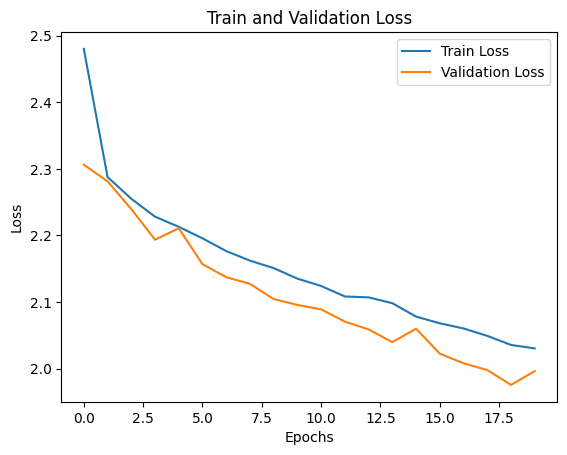

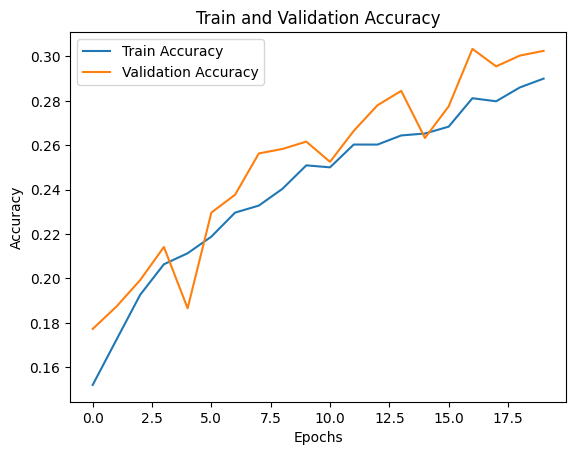

In [ ]:
 # Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
Tuned_model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
Tuned_model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = Tuned_model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/210 [00:00<?, ?it/s]

Test accuracy 0.3137896955013275


##Pretrained ResNET18

In [20]:
import torchvision.models as models

# Load pre-trained ResNet-18 model
pretrained_resnet = models.resnet18(pretrained=True)

# Freeze all the parameters in the pre-trained model
for param in pretrained_resnet.parameters():
    param.requires_grad = False

# Modify the output number of classes
num_classes = 16  # Number of
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)

# Move the model to the device
pretrained_resnet = pretrained_resnet.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_resnet.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [ ]:
# The number of training epochs
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):
    # ---------- Training ----------
    pretrained_resnet.train()

    # These are used to record information in training
    train_loss = []
    train_accs = []

    # Iterate over the training set by batches
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = pretrained_resnet(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    pretrained_resnet.eval()

    # These are used to record information in validation
    valid_loss = []
    valid_accs = []

    # Iterate over the validation set by batches
    for batch in tqdm(val_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = pretrained_resnet(imgs)
            loss = criterion(logits, labels)
            acc = (logits.argmax(dim=-1) == labels).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # Save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(pretrained_resnet.state_dict(), 'best_model.pth')

    # Print the information
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=2.12375, acc=0.27206 | Valid: loss=1.76785, acc=0.40039


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=1.73873, acc=0.43531 | Valid: loss=1.42104, acc=0.55843


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=1.54538, acc=0.51246 | Valid: loss=1.25141, acc=0.60678


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=1.43787, acc=0.54285 | Valid: loss=1.13400, acc=0.65727


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=1.36218, acc=0.56345 | Valid: loss=1.07743, acc=0.66269


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=1.30962, acc=0.58006 | Valid: loss=1.02240, acc=0.68285


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=1.26935, acc=0.59421 | Valid: loss=0.96156, acc=0.69806


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=1.23879, acc=0.59933 | Valid: loss=0.97997, acc=0.68992


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=1.20806, acc=0.60942 | Valid: loss=0.93567, acc=0.70145


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=1.19876, acc=0.60788 | Valid: loss=0.90195, acc=0.71279


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=1.17511, acc=0.61621 | Valid: loss=0.91934, acc=0.70543


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=1.15400, acc=0.62062 | Valid: loss=0.89138, acc=0.71492


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=1.15933, acc=0.61700 | Valid: loss=0.88328, acc=0.71066


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=1.12572, acc=0.62792 | Valid: loss=0.87885, acc=0.71434


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=1.13063, acc=0.62638 | Valid: loss=0.86270, acc=0.72190


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=1.12062, acc=0.62654 | Valid: loss=0.84589, acc=0.72132


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=1.09972, acc=0.63215 | Valid: loss=0.84104, acc=0.72461


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=1.10221, acc=0.63167 | Valid: loss=0.83975, acc=0.72190


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=1.09267, acc=0.63620 | Valid: loss=0.84697, acc=0.72422


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=1.09752, acc=0.63793 | Valid: loss=0.86330, acc=0.71986


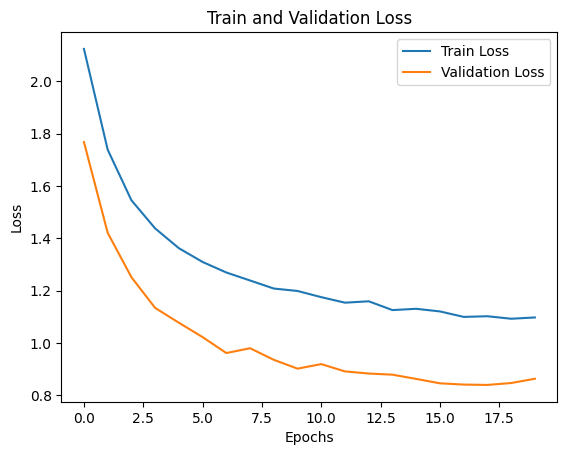

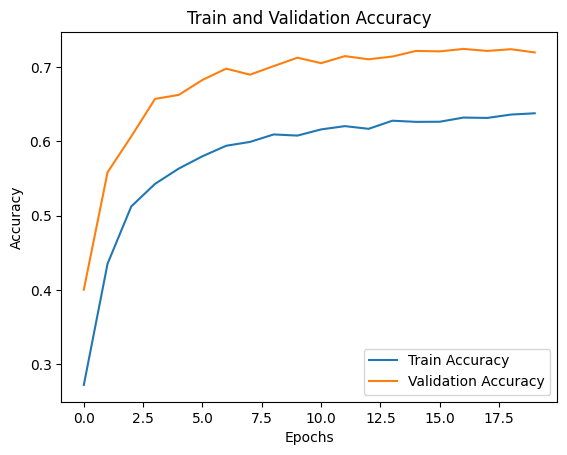

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
pretrained_resnet.load_state_dict(torch.load('best_model.pth'))

pretrained_resnet.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = pretrained_resnet(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/210 [00:00<?, ?it/s]

Test accuracy 0.7513889670372009


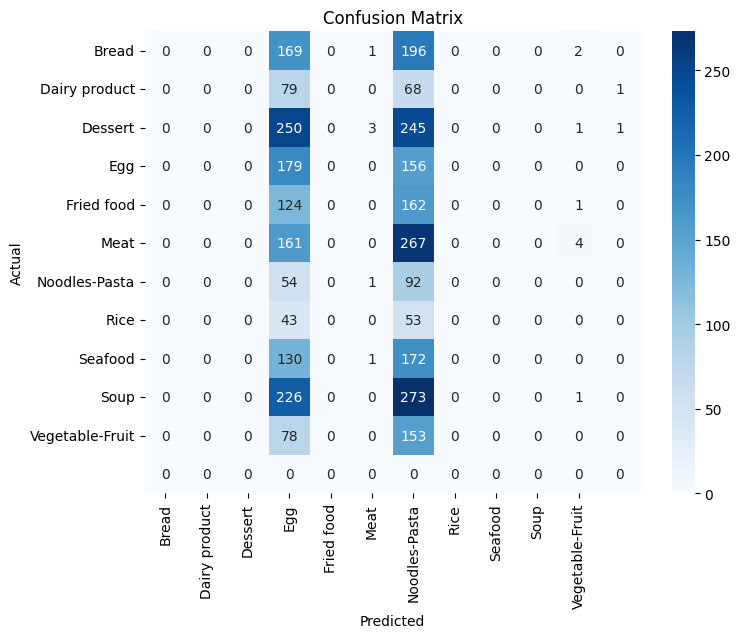

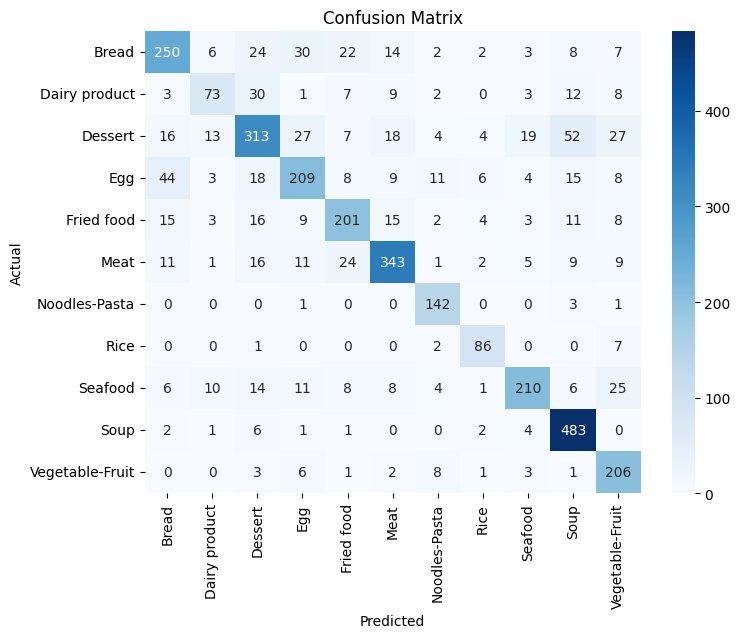

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to compute and plot the confusion matrix
def plot_confusion_matrix(model, data_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    # Iterate over the test set
    with torch.no_grad():
        for batch in data_loader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming 'class_names' is a list of class names
class_names = train_dataset.classes

# Plot confusion matrix for the tuned model
plot_confusion_matrix(Tuned_model, test_loader, class_names)

# Load the best pretrained ResNet model
pretrained_resnet.load_state_dict(torch.load('best_model.pth'))

# Plot confusion matrix for the pretrained ResNet model
plot_confusion_matrix(pretrained_resnet, test_loader, class_names)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# Function to get predictions and true labels for the test set
def get_predictions_and_labels(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    for batch in test_loader:
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            preds = logits.argmax(dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

# Get predictions and true labels
tuned_predictions, tuned_labels = get_predictions_and_labels(Tuned_model, test_loader)
pretrained_predictions, pretrained_labels = get_predictions_and_labels(pretrained_resnet, test_loader)


In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



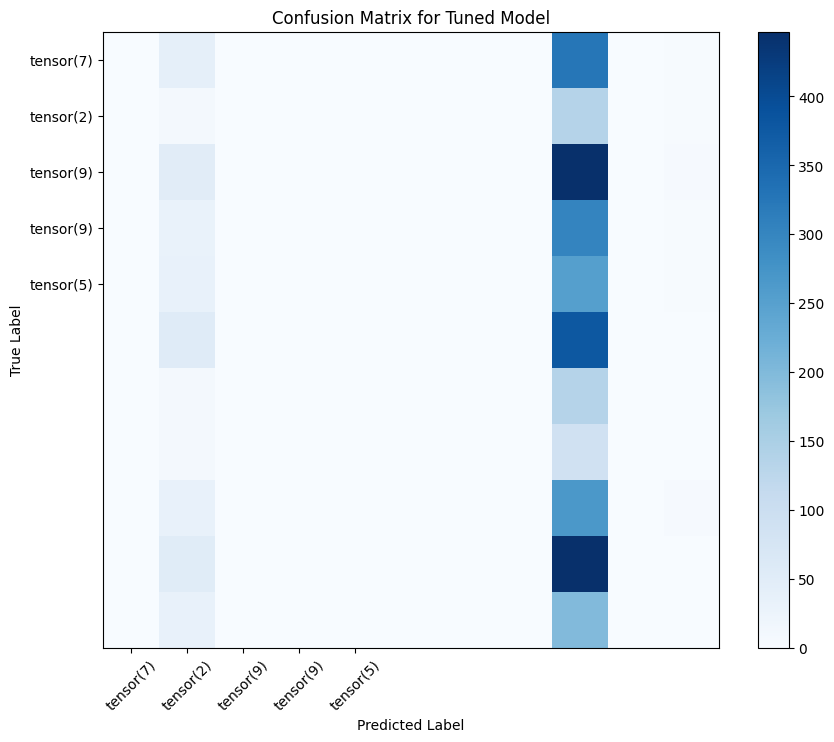

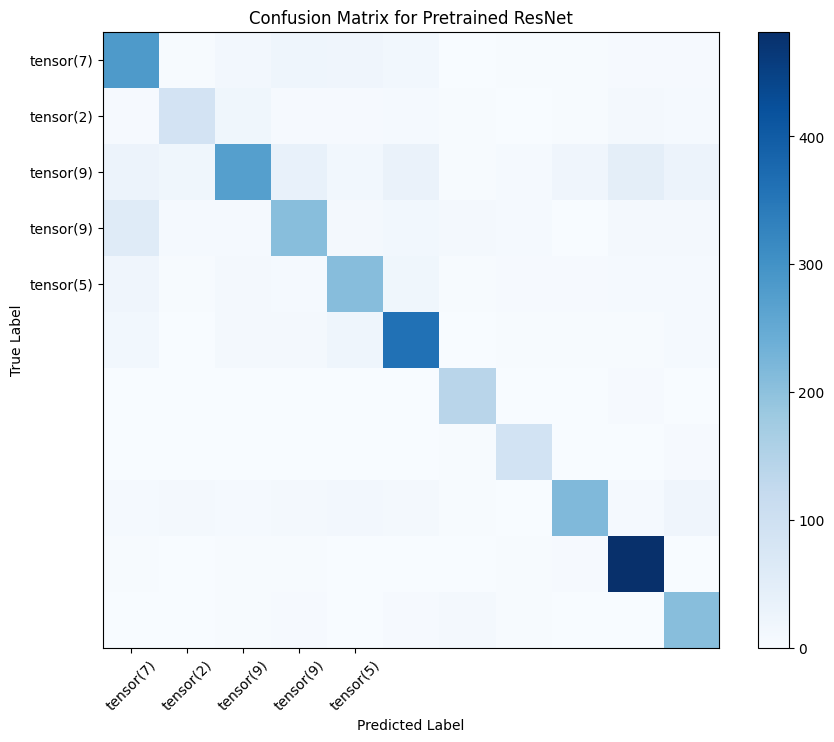

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
# Plot confusion matrix for Tuned Model
plot_confusion_matrix(tuned_labels, tuned_predictions, title='Confusion Matrix for Tuned Model')

# Plot confusion matrix for Pretrained ResNet
plot_confusion_matrix(pretrained_labels, pretrained_predictions, title='Confusion Matrix for Pretrained ResNet')

# Plot ROC-AUC curve
def plot_roc_curve(y_true, y_pred_probs, title):
    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
        auc_score = roc_auc_score(y_true == i, y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Get prediction probabilities for Tuned Model
tuned_logits = torch.softmax(Tuned_model(imgs), dim=-1).cpu().numpy()
# Plot ROC-AUC curve for Tuned Model
plot_roc_curve(tuned_labels, tuned_logits, title='ROC-AUC Curve for Tuned Model')

# Get prediction probabilities for Pretrained ResNet
pretrained_logits = torch.softmax(pretrained_resnet(imgs), dim=-1).cpu().numpy()
# Plot ROC-AUC curve for Pretrained ResNet
plot_roc_curve(pretrained_labels, pretrained_logits, title='ROC-AUC Curve for Pretrained ResNet')

##Pre-trained VGG16

In [ ]:
vgg = models.vgg16(pretrained=True)
num_ftrs = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_ftrs, 16)  # Adjust the output features to match your number of classes
vgg = vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim  # Importing optim from torch
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
# The number of training epochs
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):
    # ---------- Training ----------
    vgg.train()

    # These are used to record information in training
    train_loss = []
    train_accs = []

    # Iterate over the training set by batches
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = vgg(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    pretrained_resnet.eval()

    # These are used to record information in validation
    valid_loss = []
    valid_accs = []

    # Iterate over the validation set by batches
    for batch in tqdm(val_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = vgg(imgs)
            loss = criterion(logits, labels)
            acc = (logits.argmax(dim=-1) == labels).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # Save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(vgg.state_dict(), 'best_model.pth')

    # Print the information
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=2.92372, acc=0.04477 | Valid: loss=2.95342, acc=0.04390


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=2.92300, acc=0.04518 | Valid: loss=2.95689, acc=0.04506


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=2.92636, acc=0.04376 | Valid: loss=2.95807, acc=0.04893


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=2.92504, acc=0.04589 | Valid: loss=2.96403, acc=0.04099


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=2.92474, acc=0.04680 | Valid: loss=2.95955, acc=0.03857


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=2.92132, acc=0.04812 | Valid: loss=2.94913, acc=0.04360


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=2.92979, acc=0.04605 | Valid: loss=2.96375, acc=0.04971


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=2.93159, acc=0.04402 | Valid: loss=2.95719, acc=0.04012


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=2.92042, acc=0.04923 | Valid: loss=2.95545, acc=0.04709


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=2.93575, acc=0.04392 | Valid: loss=2.96511, acc=0.04448


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=2.92985, acc=0.04469 | Valid: loss=2.95376, acc=0.04070


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=2.92645, acc=0.04591 | Valid: loss=2.97258, acc=0.05048


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=2.92549, acc=0.04372 | Valid: loss=2.97105, acc=0.04128


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=2.92917, acc=0.04335 | Valid: loss=2.95250, acc=0.05000


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=2.92364, acc=0.04163 | Valid: loss=2.96309, acc=0.04826


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=2.92802, acc=0.04585 | Valid: loss=2.96353, acc=0.04070


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=2.93550, acc=0.04342 | Valid: loss=2.95987, acc=0.04496


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=2.92744, acc=0.04605 | Valid: loss=2.95920, acc=0.04331


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=2.92765, acc=0.04773 | Valid: loss=2.96626, acc=0.04118


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=2.93331, acc=0.04874 | Valid: loss=2.96338, acc=0.04564


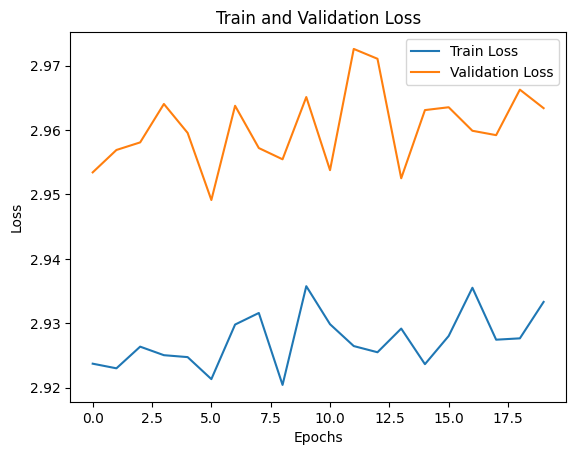

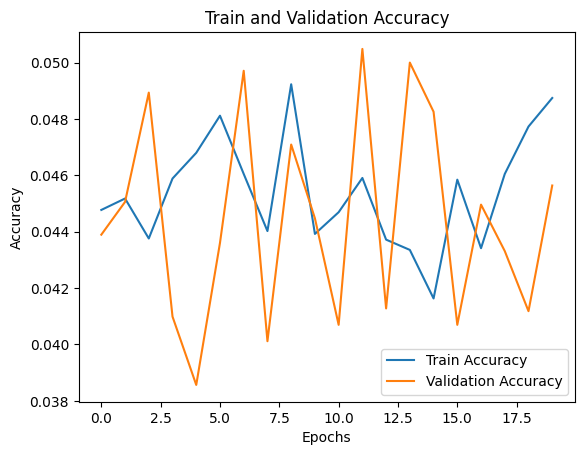

In [ ]:
 # Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
vgg.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
vgg.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = vgg(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/210 [00:00<?, ?it/s]

Test accuracy 0.02470238134264946
